In [1]:
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
# load data
with open('./cifar_10_tf_train_test.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    train_x, train_y, test_x, test_y = u.load()

In [3]:
# onehot encode y samples with n classes
def onehot_encode(y, n):
    ret = np.zeros((len(y), n))
    for i in range(len(y)):
        ret[i, int(y[i])-1] = 1
    return ret

# normalize
def normalize(x):
    minn = np.min(x)
    maxx = np.max(x)
    return (x - minn) / (maxx - minn)

In [4]:
X_train = np.transpose(normalize(train_x).astype(np.float32), (0,2,1,3)) # 50000 * 32 * 32 * 3
X_test = np.transpose(normalize(test_x).astype(np.float32), (0,2,1,3)) # 5000 * 32 * 32 * 3

# Y_train = onehot_encode(train_y, 10) # 50000 * 10
# Y_test = onehot_encode(test_y, 10) # 5000 * 10
Y_train = train_y
Y_test = test_y

In [17]:
lr = 0.001
batch_size = 100
n_batches = int(50000 / batch_size)

In [8]:
tf.reset_default_graph()

x = tf.placeholder(shape=[None, 32, 32, 3], dtype=tf.float32)
y = tf.placeholder(shape=[None], dtype=tf.int64)

In [57]:
weights = {'w1': tf.Variable(tf.random_normal([5,5,3,32], stddev = 0.1, name='w1')),
           'w2': tf.Variable(tf.random_normal([5,5,32,32], stddev = 0.1, name='w2')), 
           'w3': tf.Variable(tf.random_normal([3,3,32,64], stddev = 0.1, name='w3')), 
           'w4': tf.Variable(tf.random_normal([3*3*64,10], stddev = 0.1, name='w4'))}

biases = {'b1': tf.Variable(tf.random_normal([32],stddev = 0.1, name='b1')),
          'b2': tf.Variable(tf.random_normal([32],stddev = 0.1, name='b2')),
          'b3': tf.Variable(tf.random_normal([64],stddev = 0.1, name='b3')),
          'b4': tf.Variable(tf.random_normal([10],stddev = 0.1, name='b4'))}

In [11]:
def model(x, w, b):
    conv1 = tf.nn.conv2d(x, filter=w['w1'],strides=[1,1,1,1], padding='VALID') # [None,28,28,32]
    conv1 = tf.nn.bias_add(conv1, b['b1'])
    acti1 = tf.nn.relu(conv1)
    pool1 = tf.nn.max_pool(acti1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID') # [None,14,14,32]
    c_nb1 = tf.layers.batch_normalization(pool1)

    conv2 = tf.nn.conv2d(c_nb1, filter=w['w2'],strides=[1,1,1,1], padding='VALID') # [None,10,10,32]
    conv2 = tf.nn.bias_add(conv2, b['b2'])
    acti2 = tf.nn.relu(conv2)
    pool2 = tf.nn.max_pool(acti2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID') # [None,5,5,32]
    c_nb2 = tf.layers.batch_normalization(pool2)
    
    conv3 = tf.nn.conv2d(c_nb2, filter=w['w3'], strides=[1,1,1,1], padding='VALID') # [None,3,3,64]
    conv3 = tf.nn.bias_add(conv3, b['b3'])
    acti3 = tf.nn.relu(conv3)
    c_nb3 = tf.layers.batch_normalization(acti3)

    fc1 = tf.contrib.layers.flatten(c_nb3)

    out = tf.matmul(fc1, w['w4'])
    out = tf.nn.bias_add(out, b['b4'])
    
    return out, tf.nn.softmax(out)

In [12]:
out, out_softmax = model(x, weights, biases)
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=out, labels=y))

In [13]:
optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

In [14]:
predict_op = tf.argmax(out, axis=1)
true_label_op = tf.argmax(y, axis=1)
accuracy = tf.reduce_mean(tf.cast(tf.equal(predict_op, y), tf.float32))

In [15]:
# Save the model
tf.get_collection('validation_nodes')

# Add opts to the collection
tf.add_to_collection('validation_nodes', x)
tf.add_to_collection('validation_nodes', y)
tf.add_to_collection('validation_nodes', predict_op)

saver = tf.train.Saver()

In [58]:
train_accs = []
test_accs = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(40):
        for i in range(n_batches):
            X_batch = X_train[i*batch_size:(i+1)*batch_size]
            Y_batch = Y_train[i*batch_size:(i+1)*batch_size]
            
            _, acc, l = sess.run([optimizer, accuracy, loss], feed_dict={x:X_batch, y:Y_batch})
            
            if i % 10 == 0:
                print('epoch: {} batch: {} acc: {:.3f} loss: {:.3f}'.format(epoch, i, acc, l))
            
        train_acc = sess.run(accuracy, feed_dict={x:X_train, y:Y_train})
        test_predict, test_acc = sess.run([out, accuracy], feed_dict={x:X_test, y:Y_test})
        
        print('-------------------------------------------')
        print('End of training epoch {}'.format(epoch))
        print('train acc: {}'.format(train_acc))
        print('test acc: {}'.format(test_acc))
        print('-------------------------------------------')
        
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        
    save_path = saver.save(sess, "./my_model")

epoch: 0 batch: 0 acc: 0.040 loss: 4.542
epoch: 0 batch: 10 acc: 0.110 loss: 2.647
epoch: 0 batch: 20 acc: 0.090 loss: 2.418
epoch: 0 batch: 30 acc: 0.100 loss: 2.387
epoch: 0 batch: 40 acc: 0.150 loss: 2.312
epoch: 0 batch: 50 acc: 0.240 loss: 2.216
epoch: 0 batch: 60 acc: 0.190 loss: 2.201
epoch: 0 batch: 70 acc: 0.320 loss: 2.026
epoch: 0 batch: 80 acc: 0.200 loss: 2.174
epoch: 0 batch: 90 acc: 0.240 loss: 2.088
epoch: 0 batch: 100 acc: 0.260 loss: 2.085
epoch: 0 batch: 110 acc: 0.270 loss: 1.944
epoch: 0 batch: 120 acc: 0.260 loss: 2.015
epoch: 0 batch: 130 acc: 0.210 loss: 1.941
epoch: 0 batch: 140 acc: 0.290 loss: 1.940
epoch: 0 batch: 150 acc: 0.220 loss: 2.158
epoch: 0 batch: 160 acc: 0.270 loss: 1.911
epoch: 0 batch: 170 acc: 0.300 loss: 1.908
epoch: 0 batch: 180 acc: 0.290 loss: 1.852
epoch: 0 batch: 190 acc: 0.340 loss: 1.870
epoch: 0 batch: 200 acc: 0.310 loss: 1.951
epoch: 0 batch: 210 acc: 0.300 loss: 1.851
epoch: 0 batch: 220 acc: 0.330 loss: 1.894
epoch: 0 batch: 230 ac

epoch: 3 batch: 300 acc: 0.580 loss: 1.243
epoch: 3 batch: 310 acc: 0.510 loss: 1.247
epoch: 3 batch: 320 acc: 0.530 loss: 1.376
epoch: 3 batch: 330 acc: 0.410 loss: 1.511
epoch: 3 batch: 340 acc: 0.560 loss: 1.352
epoch: 3 batch: 350 acc: 0.630 loss: 1.130
epoch: 3 batch: 360 acc: 0.610 loss: 1.221
epoch: 3 batch: 370 acc: 0.600 loss: 1.203
epoch: 3 batch: 380 acc: 0.570 loss: 1.311
epoch: 3 batch: 390 acc: 0.490 loss: 1.355
epoch: 3 batch: 400 acc: 0.630 loss: 1.043
epoch: 3 batch: 410 acc: 0.520 loss: 1.286
epoch: 3 batch: 420 acc: 0.500 loss: 1.338
epoch: 3 batch: 430 acc: 0.490 loss: 1.340
epoch: 3 batch: 440 acc: 0.500 loss: 1.286
epoch: 3 batch: 450 acc: 0.640 loss: 1.070
epoch: 3 batch: 460 acc: 0.600 loss: 1.200
epoch: 3 batch: 470 acc: 0.490 loss: 1.285
epoch: 3 batch: 480 acc: 0.480 loss: 1.456
epoch: 3 batch: 490 acc: 0.530 loss: 1.301
-------------------------------------------
End of training epoch 3
train acc: 0.5577600002288818
test acc: 0.5432000160217285
-------------

epoch: 7 batch: 60 acc: 0.530 loss: 1.149
epoch: 7 batch: 70 acc: 0.630 loss: 1.103
epoch: 7 batch: 80 acc: 0.620 loss: 1.122
epoch: 7 batch: 90 acc: 0.550 loss: 1.175
epoch: 7 batch: 100 acc: 0.580 loss: 1.079
epoch: 7 batch: 110 acc: 0.580 loss: 1.266
epoch: 7 batch: 120 acc: 0.630 loss: 1.120
epoch: 7 batch: 130 acc: 0.570 loss: 1.219
epoch: 7 batch: 140 acc: 0.560 loss: 1.147
epoch: 7 batch: 150 acc: 0.570 loss: 1.133
epoch: 7 batch: 160 acc: 0.620 loss: 1.160
epoch: 7 batch: 170 acc: 0.610 loss: 1.032
epoch: 7 batch: 180 acc: 0.640 loss: 1.060
epoch: 7 batch: 190 acc: 0.600 loss: 1.085
epoch: 7 batch: 200 acc: 0.590 loss: 1.146
epoch: 7 batch: 210 acc: 0.640 loss: 1.011
epoch: 7 batch: 220 acc: 0.610 loss: 1.111
epoch: 7 batch: 230 acc: 0.640 loss: 1.040
epoch: 7 batch: 240 acc: 0.590 loss: 1.096
epoch: 7 batch: 250 acc: 0.630 loss: 1.095
epoch: 7 batch: 260 acc: 0.650 loss: 1.015
epoch: 7 batch: 270 acc: 0.590 loss: 1.204
epoch: 7 batch: 280 acc: 0.650 loss: 0.988
epoch: 7 batch:

epoch: 10 batch: 350 acc: 0.750 loss: 0.882
epoch: 10 batch: 360 acc: 0.730 loss: 0.860
epoch: 10 batch: 370 acc: 0.650 loss: 0.961
epoch: 10 batch: 380 acc: 0.640 loss: 1.045
epoch: 10 batch: 390 acc: 0.560 loss: 1.088
epoch: 10 batch: 400 acc: 0.720 loss: 0.816
epoch: 10 batch: 410 acc: 0.700 loss: 0.942
epoch: 10 batch: 420 acc: 0.600 loss: 1.043
epoch: 10 batch: 430 acc: 0.530 loss: 1.139
epoch: 10 batch: 440 acc: 0.720 loss: 0.920
epoch: 10 batch: 450 acc: 0.760 loss: 0.783
epoch: 10 batch: 460 acc: 0.670 loss: 0.985
epoch: 10 batch: 470 acc: 0.600 loss: 1.082
epoch: 10 batch: 480 acc: 0.590 loss: 1.147
epoch: 10 batch: 490 acc: 0.700 loss: 0.891
-------------------------------------------
End of training epoch 10
train acc: 0.6586800217628479
test acc: 0.6197999715805054
-------------------------------------------
epoch: 11 batch: 0 acc: 0.720 loss: 0.839
epoch: 11 batch: 10 acc: 0.670 loss: 0.967
epoch: 11 batch: 20 acc: 0.670 loss: 1.054
epoch: 11 batch: 30 acc: 0.540 loss: 1.1

epoch: 14 batch: 70 acc: 0.660 loss: 0.941
epoch: 14 batch: 80 acc: 0.640 loss: 0.982
epoch: 14 batch: 90 acc: 0.610 loss: 0.957
epoch: 14 batch: 100 acc: 0.710 loss: 0.874
epoch: 14 batch: 110 acc: 0.610 loss: 1.060
epoch: 14 batch: 120 acc: 0.690 loss: 0.885
epoch: 14 batch: 130 acc: 0.620 loss: 0.984
epoch: 14 batch: 140 acc: 0.690 loss: 0.923
epoch: 14 batch: 150 acc: 0.650 loss: 0.903
epoch: 14 batch: 160 acc: 0.710 loss: 0.877
epoch: 14 batch: 170 acc: 0.690 loss: 0.829
epoch: 14 batch: 180 acc: 0.670 loss: 0.914
epoch: 14 batch: 190 acc: 0.720 loss: 0.894
epoch: 14 batch: 200 acc: 0.670 loss: 0.913
epoch: 14 batch: 210 acc: 0.710 loss: 0.807
epoch: 14 batch: 220 acc: 0.670 loss: 0.948
epoch: 14 batch: 230 acc: 0.720 loss: 0.898
epoch: 14 batch: 240 acc: 0.660 loss: 0.880
epoch: 14 batch: 250 acc: 0.720 loss: 0.853
epoch: 14 batch: 260 acc: 0.670 loss: 0.841
epoch: 14 batch: 270 acc: 0.650 loss: 1.033
epoch: 14 batch: 280 acc: 0.740 loss: 0.760
epoch: 14 batch: 290 acc: 0.630 los

epoch: 17 batch: 330 acc: 0.650 loss: 1.040
epoch: 17 batch: 340 acc: 0.710 loss: 0.909
epoch: 17 batch: 350 acc: 0.740 loss: 0.816
epoch: 17 batch: 360 acc: 0.770 loss: 0.764
epoch: 17 batch: 370 acc: 0.690 loss: 0.845
epoch: 17 batch: 380 acc: 0.660 loss: 0.874
epoch: 17 batch: 390 acc: 0.650 loss: 0.927
epoch: 17 batch: 400 acc: 0.770 loss: 0.710
epoch: 17 batch: 410 acc: 0.740 loss: 0.783
epoch: 17 batch: 420 acc: 0.620 loss: 0.959
epoch: 17 batch: 430 acc: 0.610 loss: 1.012
epoch: 17 batch: 440 acc: 0.790 loss: 0.750
epoch: 17 batch: 450 acc: 0.790 loss: 0.638
epoch: 17 batch: 460 acc: 0.660 loss: 0.857
epoch: 17 batch: 470 acc: 0.650 loss: 0.976
epoch: 17 batch: 480 acc: 0.670 loss: 1.047
epoch: 17 batch: 490 acc: 0.750 loss: 0.757
-------------------------------------------
End of training epoch 17
train acc: 0.7026799917221069
test acc: 0.6510000228881836
-------------------------------------------
epoch: 18 batch: 0 acc: 0.720 loss: 0.685
epoch: 18 batch: 10 acc: 0.650 loss: 0

epoch: 21 batch: 50 acc: 0.630 loss: 1.031
epoch: 21 batch: 60 acc: 0.660 loss: 0.887
epoch: 21 batch: 70 acc: 0.680 loss: 0.864
epoch: 21 batch: 80 acc: 0.690 loss: 0.921
epoch: 21 batch: 90 acc: 0.650 loss: 0.850
epoch: 21 batch: 100 acc: 0.750 loss: 0.747
epoch: 21 batch: 110 acc: 0.660 loss: 0.897
epoch: 21 batch: 120 acc: 0.740 loss: 0.778
epoch: 21 batch: 130 acc: 0.650 loss: 0.875
epoch: 21 batch: 140 acc: 0.730 loss: 0.801
epoch: 21 batch: 150 acc: 0.710 loss: 0.781
epoch: 21 batch: 160 acc: 0.780 loss: 0.716
epoch: 21 batch: 170 acc: 0.690 loss: 0.711
epoch: 21 batch: 180 acc: 0.700 loss: 0.809
epoch: 21 batch: 190 acc: 0.710 loss: 0.795
epoch: 21 batch: 200 acc: 0.690 loss: 0.766
epoch: 21 batch: 210 acc: 0.740 loss: 0.670
epoch: 21 batch: 220 acc: 0.720 loss: 0.820
epoch: 21 batch: 230 acc: 0.750 loss: 0.776
epoch: 21 batch: 240 acc: 0.720 loss: 0.747
epoch: 21 batch: 250 acc: 0.730 loss: 0.755
epoch: 21 batch: 260 acc: 0.720 loss: 0.711
epoch: 21 batch: 270 acc: 0.700 loss:

epoch: 24 batch: 310 acc: 0.730 loss: 0.760
epoch: 24 batch: 320 acc: 0.730 loss: 0.751
epoch: 24 batch: 330 acc: 0.700 loss: 0.933
epoch: 24 batch: 340 acc: 0.770 loss: 0.787
epoch: 24 batch: 350 acc: 0.770 loss: 0.749
epoch: 24 batch: 360 acc: 0.810 loss: 0.705
epoch: 24 batch: 370 acc: 0.720 loss: 0.794
epoch: 24 batch: 380 acc: 0.750 loss: 0.787
epoch: 24 batch: 390 acc: 0.700 loss: 0.804
epoch: 24 batch: 400 acc: 0.760 loss: 0.654
epoch: 24 batch: 410 acc: 0.800 loss: 0.673
epoch: 24 batch: 420 acc: 0.690 loss: 0.894
epoch: 24 batch: 430 acc: 0.670 loss: 0.854
epoch: 24 batch: 440 acc: 0.810 loss: 0.707
epoch: 24 batch: 450 acc: 0.840 loss: 0.563
epoch: 24 batch: 460 acc: 0.730 loss: 0.781
epoch: 24 batch: 470 acc: 0.660 loss: 0.971
epoch: 24 batch: 480 acc: 0.660 loss: 0.969
epoch: 24 batch: 490 acc: 0.760 loss: 0.689
-------------------------------------------
End of training epoch 24
train acc: 0.7303000092506409
test acc: 0.656000018119812
-------------------------------------

epoch: 28 batch: 30 acc: 0.710 loss: 0.727
epoch: 28 batch: 40 acc: 0.750 loss: 0.736
epoch: 28 batch: 50 acc: 0.640 loss: 0.981
epoch: 28 batch: 60 acc: 0.670 loss: 0.810
epoch: 28 batch: 70 acc: 0.700 loss: 0.799
epoch: 28 batch: 80 acc: 0.740 loss: 0.827
epoch: 28 batch: 90 acc: 0.710 loss: 0.748
epoch: 28 batch: 100 acc: 0.780 loss: 0.647
epoch: 28 batch: 110 acc: 0.700 loss: 0.780
epoch: 28 batch: 120 acc: 0.750 loss: 0.663
epoch: 28 batch: 130 acc: 0.730 loss: 0.807
epoch: 28 batch: 140 acc: 0.750 loss: 0.716
epoch: 28 batch: 150 acc: 0.760 loss: 0.644
epoch: 28 batch: 160 acc: 0.780 loss: 0.661
epoch: 28 batch: 170 acc: 0.740 loss: 0.617
epoch: 28 batch: 180 acc: 0.750 loss: 0.739
epoch: 28 batch: 190 acc: 0.700 loss: 0.730
epoch: 28 batch: 200 acc: 0.760 loss: 0.675
epoch: 28 batch: 210 acc: 0.770 loss: 0.588
epoch: 28 batch: 220 acc: 0.780 loss: 0.734
epoch: 28 batch: 230 acc: 0.810 loss: 0.673
epoch: 28 batch: 240 acc: 0.760 loss: 0.655
epoch: 28 batch: 250 acc: 0.780 loss: 0

epoch: 31 batch: 290 acc: 0.720 loss: 0.685
epoch: 31 batch: 300 acc: 0.770 loss: 0.609
epoch: 31 batch: 310 acc: 0.750 loss: 0.743
epoch: 31 batch: 320 acc: 0.740 loss: 0.686
epoch: 31 batch: 330 acc: 0.690 loss: 0.849
epoch: 31 batch: 340 acc: 0.810 loss: 0.689
epoch: 31 batch: 350 acc: 0.780 loss: 0.658
epoch: 31 batch: 360 acc: 0.770 loss: 0.710
epoch: 31 batch: 370 acc: 0.740 loss: 0.748
epoch: 31 batch: 380 acc: 0.740 loss: 0.692
epoch: 31 batch: 390 acc: 0.710 loss: 0.745
epoch: 31 batch: 400 acc: 0.780 loss: 0.553
epoch: 31 batch: 410 acc: 0.790 loss: 0.605
epoch: 31 batch: 420 acc: 0.750 loss: 0.810
epoch: 31 batch: 430 acc: 0.700 loss: 0.774
epoch: 31 batch: 440 acc: 0.830 loss: 0.605
epoch: 31 batch: 450 acc: 0.840 loss: 0.514
epoch: 31 batch: 460 acc: 0.720 loss: 0.771
epoch: 31 batch: 470 acc: 0.710 loss: 0.889
epoch: 31 batch: 480 acc: 0.700 loss: 0.869
epoch: 31 batch: 490 acc: 0.790 loss: 0.614
-------------------------------------------
End of training epoch 31
train a

epoch: 35 batch: 10 acc: 0.780 loss: 0.696
epoch: 35 batch: 20 acc: 0.760 loss: 0.745
epoch: 35 batch: 30 acc: 0.780 loss: 0.635
epoch: 35 batch: 40 acc: 0.760 loss: 0.632
epoch: 35 batch: 50 acc: 0.670 loss: 0.883
epoch: 35 batch: 60 acc: 0.740 loss: 0.716
epoch: 35 batch: 70 acc: 0.740 loss: 0.732
epoch: 35 batch: 80 acc: 0.780 loss: 0.735
epoch: 35 batch: 90 acc: 0.770 loss: 0.686
epoch: 35 batch: 100 acc: 0.770 loss: 0.581
epoch: 35 batch: 110 acc: 0.690 loss: 0.700
epoch: 35 batch: 120 acc: 0.760 loss: 0.581
epoch: 35 batch: 130 acc: 0.750 loss: 0.741
epoch: 35 batch: 140 acc: 0.790 loss: 0.638
epoch: 35 batch: 150 acc: 0.820 loss: 0.533
epoch: 35 batch: 160 acc: 0.770 loss: 0.628
epoch: 35 batch: 170 acc: 0.780 loss: 0.542
epoch: 35 batch: 180 acc: 0.780 loss: 0.676
epoch: 35 batch: 190 acc: 0.740 loss: 0.674
epoch: 35 batch: 200 acc: 0.790 loss: 0.591
epoch: 35 batch: 210 acc: 0.820 loss: 0.514
epoch: 35 batch: 220 acc: 0.790 loss: 0.682
epoch: 35 batch: 230 acc: 0.860 loss: 0.5

epoch: 38 batch: 270 acc: 0.730 loss: 0.813
epoch: 38 batch: 280 acc: 0.820 loss: 0.509
epoch: 38 batch: 290 acc: 0.720 loss: 0.643
epoch: 38 batch: 300 acc: 0.830 loss: 0.519
epoch: 38 batch: 310 acc: 0.770 loss: 0.686
epoch: 38 batch: 320 acc: 0.750 loss: 0.651
epoch: 38 batch: 330 acc: 0.730 loss: 0.782
epoch: 38 batch: 340 acc: 0.810 loss: 0.615
epoch: 38 batch: 350 acc: 0.800 loss: 0.585
epoch: 38 batch: 360 acc: 0.790 loss: 0.703
epoch: 38 batch: 370 acc: 0.780 loss: 0.642
epoch: 38 batch: 380 acc: 0.800 loss: 0.600
epoch: 38 batch: 390 acc: 0.780 loss: 0.651
epoch: 38 batch: 400 acc: 0.840 loss: 0.484
epoch: 38 batch: 410 acc: 0.830 loss: 0.515
epoch: 38 batch: 420 acc: 0.740 loss: 0.739
epoch: 38 batch: 430 acc: 0.710 loss: 0.708
epoch: 38 batch: 440 acc: 0.840 loss: 0.528
epoch: 38 batch: 450 acc: 0.840 loss: 0.451
epoch: 38 batch: 460 acc: 0.750 loss: 0.724
epoch: 38 batch: 470 acc: 0.740 loss: 0.809
epoch: 38 batch: 480 acc: 0.710 loss: 0.813
epoch: 38 batch: 490 acc: 0.800 

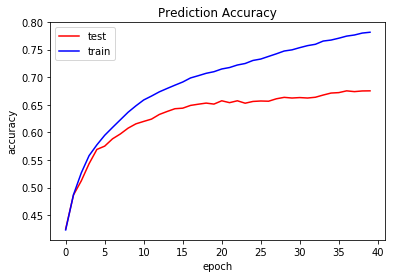

In [59]:
plt.plot(range(len(test_accs)), test_accs, 'r', range(len(train_accs)), train_accs, 'b')
plt.legend(['test', 'train'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Prediction Accuracy')
plt.show()

In [64]:
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('my_model.meta')
    # Restore variables from disk.
    graph = tf.get_default_graph()
#     w1 = graph.get_tensor_by_name("w1:0")
    w1 = sess.run('w1:0')
    

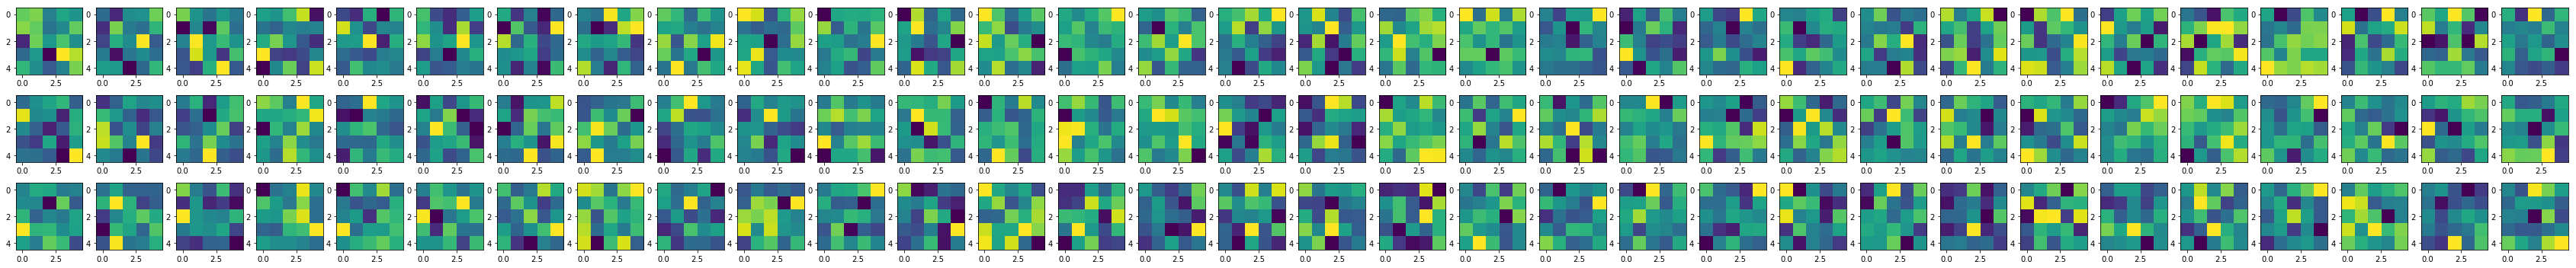

In [87]:
plt.figure(figsize=(60,6))
for i in range(3):
    for j in range(32):
        plt.subplot(3,32,i*32+j+1)
        plt.imshow(w1[:,:,i,j])
        
plt.show()

In [88]:
# code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[315   4  29   5   5   8   4   6  28  10]
 [ 34 449   7   9   3   3   5   5  31  66]
 [ 34   3 265  27  34  17  21  16  13   4]
 [ 15   5  40 285  35 121  49  29  11  14]
 [ 12   1  68  27 317  25  33  26   4   2]
 [  4   2  38  79  25 263  11  37   5   5]
 [  8   3  23  25  23   9 357   2   3   4]
 [ 14   5  28  23  56  31   2 361   6   9]
 [ 30   6  10   6   6   5   4   2 382  17]
 [ 22  27   4  11   3   6   5  11  21 382]]
Normalized confusion matrix
[[0.76 0.01 0.07 0.01 0.01 0.02 0.01 0.01 0.07 0.02]
 [0.06 0.73 0.01 0.01 0.   0.   0.01 0.01 0.05 0.11]
 [0.08 0.01 0.61 0.06 0.08 0.04 0.05 0.04 0.03 0.01]
 [0.02 0.01 0.07 0.47 0.06 0.2  0.08 0.05 0.02 0.02]
 [0.02 0.   0.13 0.05 0.62 0.05 0.06 0.05 0.01 0.  ]
 [0.01 0.   0.08 0.17 0.05 0.56 0.02 0.08 0.01 0.01]
 [0.02 0.01 0.05 0.05 0.05 0.02 0.78 0.   0.01 0.01]
 [0.03 0.01 0.05 0.04 0.1  0.06 0.   0.67 0.01 0.02]
 [0.06 0.01 0.02 0.01 0.01 0.01 0.01 0.   0.82 0.04]
 [0.04 0.05 0.01 0.02 0.

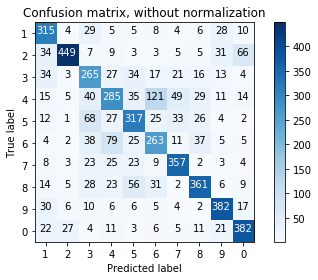

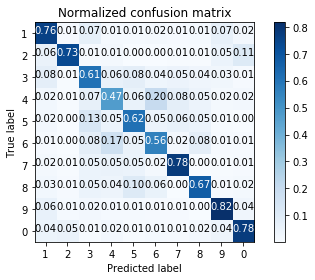

In [100]:
cnf_matrix = confusion_matrix(np.argmax(test_predict, axis=1).tolist(), Y_test)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4,5,6,7,8,9,0],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4,5,6,7,8,9,0], normalize=True,
                      title='Normalized confusion matrix')

plt.show()